# Traffic Sign Recognition Model
## Environment Initialisation

In [1]:
def IntialiseEnv():
    nb_dir = os.path.split(os.getcwd())[0]
    if nb_dir not in sys.path:
        sys.path.append(nb_dir)

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/")
!ls
import os
os.chdir("/content/drive/My Drive/Source_Code/Model")
!pip install import_ipynb

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'My Drive'


In [3]:
# Libraries
import os
import sys
import tensorflow as tf
import numpy as np
import math
IntialiseEnv()
import import_ipynb
import pickle
from sklearn.model_selection import train_test_split

from Data_Preparation.Data_Preparation import LoadTrainDataSetWithAugmentation
from Data_Preparation.Data_Preparation import LoadTrainDataSet
from Data_Preparation.Data_Preparation import LoadTestDataSet

importing Jupyter notebook from /content/drive/.shortcut-targets-by-id/1zjkLEtrgLCalQx9om9YEjISmqe3bXXFt/Source_Code/Data_Preparation/Data_Preparation.ipynb
importing Jupyter notebook from /content/drive/.shortcut-targets-by-id/1zjkLEtrgLCalQx9om9YEjISmqe3bXXFt/Source_Code/Pre_Processing/SegmentationNew.ipynb
importing Jupyter notebook from /content/drive/.shortcut-targets-by-id/1zjkLEtrgLCalQx9om9YEjISmqe3bXXFt/Source_Code/Pre_Processing/Segmentation.ipynb


## Use GPU/ CPU Configuration 
Tensorflow version 2.0
Prompt to user if CPU/ GPU is in use with device name

In [4]:
# Use GPU/CPU Configurations

import tensorflow as tf
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.2.0
/device:GPU:0
Num GPUs Available:  1


## Reading DataSet
Pre-processing and Loading Train and Test DataSet respectively

In [5]:
def ReadTrainDataSet():
    print("Reading Train Pre-processed DataSet")
    processedTrainDataSet = 'Processed_DataSet/TrainDataSet.pkl'
    isProcessedTrainDataSetExits= os.path.exists(processedTrainDataSet)
    train_image_array, train_image_labels = None, None
    
    if isProcessedTrainDataSetExits:
        print("Loading Processed Train DataSet from Processed_DataSet/TrainDataSet.pkl")
        file = open(processedTrainDataSet, 'rb')
        train_image_array, train_image_labels = pickle.load(file)
        file.close()
        print("Done Loading Train DataSet.")
    else:
        print("Processed_DataSet/TrainDataSet.pkl file does not exist")
        print("Loading Train DataSet ... This may take a while.")
        train_image_array, train_image_labels =  LoadTrainDataSetWithAugmentation()
        file = open(processedTrainDataSet, 'wb')
        pickle.dump((train_image_array, train_image_labels), file, protocol=4)
        file.close()
        print("Saving pre-processed train DataSets in Processed_DataSet/TrainDataSet.pkl")
    return train_image_array, train_image_labels    

In [6]:
def ReadTestDataSet():
    processedTestDataSet = 'Processed_DataSet/TestDataSet.pkl'
    isProcessedTestDataSetExits= os.path.exists(processedTestDataSet)
    test_image_array, test_image_labels = None, None
    
    if isProcessedTestDataSetExits:
        print("Loading Processed Test DataSet from Processed_DataSet/TestDataSet.pkl")
        file = open(processedTestDataSet, 'rb')
        test_image_array, test_image_labels = pickle.load(file)
        file.close()
        print("Done Loading Test DataSet.")
    else:
        print("Processed_DataSet/TestDataSet.pkl file does not exist")
        print("Loading Test DataSet ... This may take a while.")
        test_image_array, test_image_labels = LoadTestDataSet()
        file = open(processedTestDataSet, 'wb')
        pickle.dump((test_image_array, test_image_labels), file)
        file.close()
        print("Saving pre-processed test DataSets in Processed_DataSet/TestDataSet.pkl")
    return test_image_array, test_image_labels

In [7]:
train_image_array, train_image_labels= ReadTrainDataSet()

Reading Train Pre-processed DataSet
Loading Processed Train DataSet from Processed_DataSet/TrainDataSet.pkl
Done Loading Train DataSet.


In [8]:
print(train_image_array.shape)

(158380, 60, 60, 1)


In [9]:
test_image_array, test_image_labels= ReadTestDataSet()

Loading Processed Test DataSet from Processed_DataSet/TestDataSet.pkl
Done Loading Test DataSet.


In [10]:
print(test_image_array.shape)

(12630, 60, 60, 1)


## Train-Split 
Split Train images dataset into two splits: training and validation respectively 80-20

In [11]:
image_train, image_valid,label_train, label_valid = train_test_split(train_image_array, train_image_labels,stratify=train_image_labels,test_size=0.1,random_state=43)

In [12]:
print(image_train.shape)

(142542, 60, 60, 1)


In [13]:
del train_image_array
del train_image_labels

In [14]:
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, Add
from keras.models import Sequential
from keras.engine.topology import Layer
class Residual(Layer):
    def __init__(self, channels_in,kernel,**kwargs):
        super(Residual, self).__init__(**kwargs)
        self.channels_in = channels_in
        self.kernel = kernel

    def call(self, x):
        # the residual block using Keras functional API
        first_layer =Activation("linear", trainable=False)(x)
        x = Conv2D(self.channels_in,self.kernel, padding="same")(first_layer)
        x = Activation("relu")(x)
        x = Conv2D(self.channels_in,self.kernel,padding="same")(x)
        residual= Add()([x, first_layer])
        x = Activation("relu")(residual)
        return x

    def compute_output_shape(self, input_shape):
        return input_shape

Using TensorFlow backend.


## Hyper-parameters Tuning

In [15]:
# Hyper-parameters tuning
kernel_2 = (3,3)
pooling = (2,2)
dropout = 0.2
num_classes = 43

## Model Architecture

In [16]:
weight_decay=1E-4
from keras.regularizers import l2

def model_():
    model = None
    tf.initializers.Orthogonal(gain=1.0, seed=None)
    model=Sequential()

    model.add(Conv2D(32,kernel_2, input_shape=(60,60,1), strides = 1, padding='valid',activation = tf.nn.relu,kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Conv2D(32,kernel_2, activation = tf.nn.relu,kernel_regularizer=l2(0.01)))
    model.add(MaxPool2D(pooling))
    model.add(Dropout(dropout))
    model.add(BatchNormalization())

    model.add(Conv2D(128,kernel_2, strides = 1, padding='valid', activation = tf.nn.relu,kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Conv2D(128,kernel_2, activation = tf.nn.relu,kernel_regularizer=l2(0.01)))
    model.add(MaxPool2D(pooling))
    model.add(Dropout(dropout))
    model.add(BatchNormalization())

    model.add(Conv2D(256,kernel_2, strides = 1, padding='valid', activation = tf.nn.relu,kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Conv2D(256,kernel_2, activation = tf.nn.relu,kernel_regularizer=l2(0.01)))
    model.add(MaxPool2D(pooling))
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(512, activation = tf.nn.relu))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation = 'softmax'))
    return model

## Model Optimizer 

In [17]:
from tensorflow import keras
model = model_()


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=2,  verbose=1, min_delta=1e-4, min_lr=1e-20)
# optimizer = keras.optimizers.Adadelta()

model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

## Model Training

In [ ]:
history = model.fit(image_train, np.array(label_train) , batch_size=32, epochs=10, validation_data=(image_valid, np.array(label_valid)), callbacks=[reduce_lr],shuffle=True )

Train on 142542 samples, validate on 15838 samples
Epoch 1/10
142542/142542 [==============================] - 76s 532us/step - loss: 0.0248 - sparse_categorical_accuracy: 0.9997 - val_loss: 0.0401 - val_sparse_categorical_accuracy: 0.9958
Epoch 2/10
142542/142542 [==============================] - 76s 530us/step - loss: 0.0246 - sparse_categorical_accuracy: 0.9997 - val_loss: 0.0400 - val_sparse_categorical_accuracy: 0.9961
Epoch 3/10
142542/142542 [==============================] - 76s 531us/step - loss: 0.0244 - sparse_categorical_accuracy: 0.9997 - val_loss: 0.0395 - val_sparse_categorical_accuracy: 0.9960
Epoch 4/10
142542/142542 [==============================] - 76s 532us/step - loss: 0.0243 - sparse_categorical_accuracy: 0.9998 - val_loss: 0.0398 - val_sparse_categorical_accuracy: 0.9960
Epoch 5/10
142542/142542 [==============================] - 76s 531us/step - loss: 0.0243 - sparse_categorical_accuracy: 0.9997 - val_loss: 0.0396 - val_sparse_categorical_accuracy: 0.9961
Epoc

## Model Evaluation

In [ ]:
model.evaluate(test_image_array, np.array(test_image_labels), batch_size=256)

In [33]:
model.evaluate(test_image_array, np.array(test_image_labels), batch_size=256)

12630/12630 [==============================] - 2s 121us/step


[0.051354796701919815, 0.9935867190361023]

## Visualization

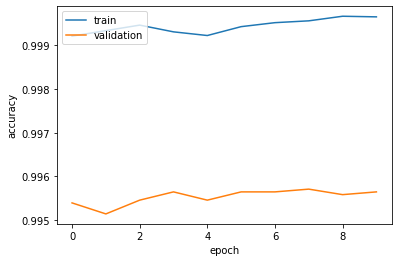

In [28]:
import matplotlib.pyplot as plt
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

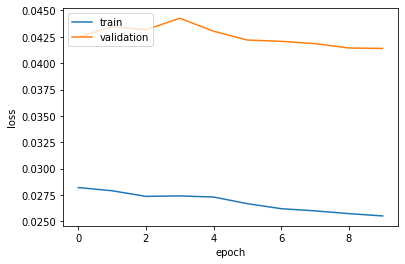

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Model Summary 
Number of parameters used in the model architecture

In [31]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 58, 58, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 58, 58, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 128)      

## Saving Trained .h5 Model

In [23]:
def saveCNNModel(model_name):
    model.save(model_name)

In [34]:
saveCNNModel('Trained_Models/winning_model_99.358.h5')

In [ ]:
model._set_inputs(image_train,np.array(label_train))

## Loading Saved Trained .h5 Model

In [ ]:
def load_model():
    Model = tf.keras.models.load_model('Trained_Models/winning_model_9925.h5')
    return Model

In [ ]:
del model
model= load_model()

## Computation Avg. Processing Time

In [ ]:
import time
t1=time.time()
model.predict(test_image_array)
t2=time.time()
print("Average Processing time: ", ((t2-t1)/12630)*1000, " ms")